In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split # for splitting the training data

from xgboost import XGBRegressor

# for cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
Kfold_validation = KFold(10) # use k=10 for cross validation

# Calculate MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Load and validate the training and testing data

In [12]:
# Load the preprocessed training data
train_processed = pd.read_csv('train_processed.csv')
print("Training data shape:", train_processed.shape)
print("Columns:", train_processed.columns.tolist())

# Separate features (X) and target (y)
y_train = train_processed['Price']
X_train = train_processed.drop(columns=['Price'])


print(f"\nFeatures shape: {X_train.shape}")
print(f"Target shape: {y_train.shape}")
print(f"\nTarget statistics:")
print(f"Mean price: {y_train.mean():.2f}")
print(f"Min price: {y_train.min():.2f}")
print(f"Max price: {y_train.max():.2f}")

# Split data into training and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=15
)
print(f"Training set: {X_train_split.shape}")
print(f"Validation set: {X_val.shape}")

Training data shape: (4336, 21)
Columns: ['Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats', 'No. of Doors', 'Price', 'Age', 'Fuel_Type_Diesel', 'Fuel_Type_Petrol', 'Fuel_Type_CNG', 'Fuel_Type_LPG', 'Transmission_Manual', 'Transmission_Automatic', 'Owner_Type_First', 'Owner_Type_Second', 'Owner_Type_Third', 'Owner_Type_Fourth & Above', 'Colour_Others', 'Colour_Black/Silver', 'Colour_White']

Features shape: (4336, 20)
Target shape: (4336,)

Target statistics:
Mean price: 9.65
Min price: 0.44
Max price: 160.00
Training set: (3468, 20)
Validation set: (868, 20)


# XGBoost Regressor model

In [16]:
# Train an XGBoost Regressor model
print("Training XGBoost model...")
xgb_model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=20,
    # eval_metric='mape',  # Use MAPE as evaluation metric
    random_state=10,
)

xgb_model.fit(
    X_train_split, 
    y_train_split,
    eval_set=[(X_train_split, y_train_split), (X_val, y_val)],  # Monitor both train and validation
    verbose=False  # Set to True to see training progress
)

# Make predictions
y_pred_train_xgb = xgb_model.predict(X_train_split)
y_pred_val_xgb = xgb_model.predict(X_val)

# Evaluate the model
print("\n=== XGBoost Model Performance ===")
print(f"Training MAPE: {calculate_mape(y_train_split, y_pred_train_xgb):.2f}%")
print(f"Validation MAPE: {calculate_mape(y_val, y_pred_val_xgb):.2f}%")

# check the cross validation
xgb_model_cross_validation_result = cross_val_score(xgb_model,X_train,y_train,cv = Kfold_validation)
print("\n=== Cross validation result ===")
print(xgb_model_cross_validation_result)
print("\n=== Cross validation mean score ===")
print(np.mean(xgb_model_cross_validation_result))


Training XGBoost model...

=== XGBoost Model Performance ===
Training MAPE: 0.08%
Validation MAPE: 20.28%

=== Cross validation result ===
[0.73964818 0.76102538 0.82693173 0.93166197 0.86699552 0.90575589
 0.85619885 0.86271887 0.88525709 0.83552851]

=== Cross validation mean score ===
0.8471721982101854


In [4]:
# Load test_processed.csv and predict the price
test_processed = pd.read_csv('test_processed.csv')
print("Test data shape:", test_processed.shape)
print("Test data columns:", test_processed.columns.tolist())

# Save ID column if it exists
X_test = test_processed.drop(columns=['ID'])

print(f"\nTest features shape: {X_test.shape}")
print(f"Training features shape: {X_train.shape}")

# Verify columns match between train and test
print(f"\nColumns match: {list(X_train.columns) == list(X_test.columns)}")

Test data shape: (1491, 21)
Test data columns: ['ID', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats', 'No. of Doors', 'Age', 'Fuel_Type_Diesel', 'Fuel_Type_Petrol', 'Fuel_Type_CNG', 'Fuel_Type_LPG', 'Transmission_Manual', 'Transmission_Automatic', 'Owner_Type_First', 'Owner_Type_Second', 'Owner_Type_Third', 'Owner_Type_Fourth & Above', 'Colour_Others', 'Colour_Black/Silver', 'Colour_White']

Test features shape: (1491, 20)
Training features shape: (4336, 20)

Columns match: True


In [5]:
# Make predictions on test data using XGBoost
y_pred_xgb = xgb_model.predict(X_test)

print("=== XGBoost Predictions ===")
print(f"Predicted prices - Min: {y_pred_xgb.min():.2f}, Max: {y_pred_xgb.max():.2f}, Mean: {y_pred_xgb.mean():.2f}")

# Save ID and predicted Price to CSV file
submission_xgb = pd.DataFrame({
    'ID': test_processed['ID'],
    'Price': y_pred_xgb
})

submission_xgb.to_csv('submission_xgboost.csv', index=False)
print("\nXGBoost submission saved as 'submission_xgboost.csv'")


=== XGBoost Predictions ===
Predicted prices - Min: 0.68, Max: 122.89, Mean: 9.63

XGBoost submission saved as 'submission_xgboost.csv'



=== Top 15 Most Important Features (XGBoost) ===
            feature  importance
              Power    0.602351
                Age    0.124529
              Seats    0.090641
Transmission_Manual    0.055691
             Engine    0.040431
   Fuel_Type_Diesel    0.030746
       Colour_White    0.013055
            Mileage    0.010661
  Kilometers_Driven    0.008343
   Owner_Type_First    0.005708
   Owner_Type_Third    0.005172
  Owner_Type_Second    0.004173
      Colour_Others    0.003710
       No. of Doors    0.002270
   Fuel_Type_Petrol    0.001043


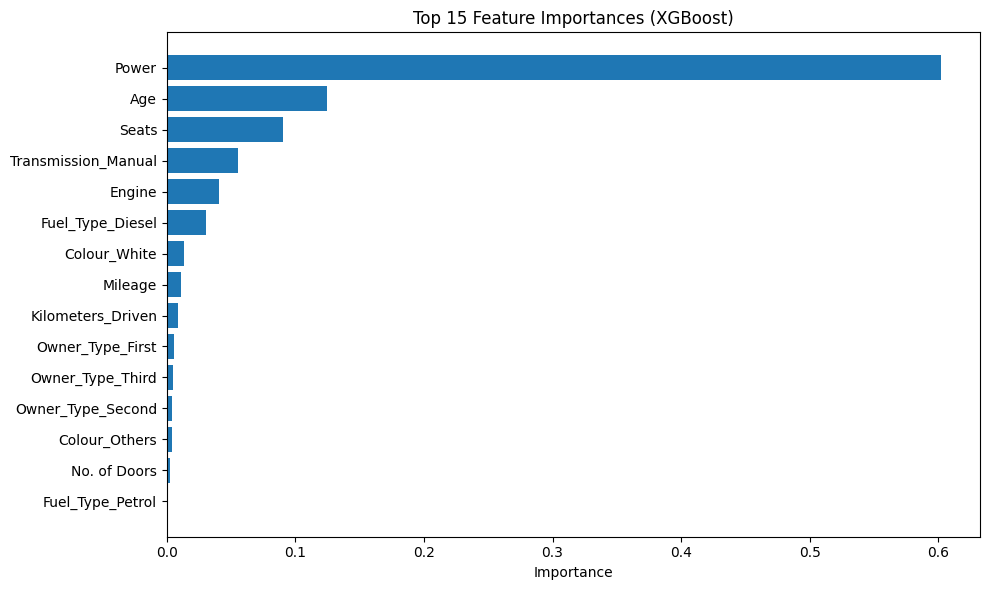

In [6]:
# Feature importance from XGBoost
import matplotlib.pyplot as plt

feature_importance_xgb = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== Top 15 Most Important Features (XGBoost) ===")
print(feature_importance_xgb.head(15).to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_xgb.head(15)['feature'], feature_importance_xgb.head(15)['importance'])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()